In [6]:
!pip install torch torchvision torchaudio scikit-learn

You should consider upgrading via the '/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import os
import sys
import argparse
import time
from tqdm import trange
import numpy as np
import PIL
import numpy as np
import random
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU instead.")
    
batch_size = 32
# Specify the root folders for neoplastic and nonneoplastic images
neoplastic_folder = './PCData/Neoplasia'
nonneoplastic_folder = './PCData/Non-neoplasia'  


nonneoplastic_data = [(os.path.join(nonneoplastic_folder, file), 0) for file in os.listdir(nonneoplastic_folder) if not file.startswith('.')]
neoplastic_data = [(os.path.join(neoplastic_folder, file), 1) for file in os.listdir(neoplastic_folder) if not file.startswith('.')]
data = neoplastic_data + nonneoplastic_data
# Create the train dataset using train_data.txt
train_data = []
train_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('train_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        train_ids.add(sdkid)


# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_train = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_train in train_ids:
        train_data.append((filepath, label))



# Create the valid dataset using valid_data.txt
valid_data = []
valid_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('valid_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        valid_ids.add(sdkid)

# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_val = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_val in valid_ids:
        valid_data.append((filepath, label))
              
# Create the test dataset using train_data.txt
test_data = []
test_ids = set()  # Define train_ids before adding elements to it
# Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
with open('test_data.txt', 'r') as file:
    for line in file:
        # Assuming train_data.txt contains data in the format: id \t ccenum \t class_type
        sdkid = line.strip().split(',')[0]
        test_ids.add(sdkid)

# Iterate through your neoplastic and nonneoplastic data
for filepath, label in data:
    filename = os.path.basename(filepath)
    sdkid_test = filename.split('_')[0]  # Assuming sdkid is the prefix before '_'
    #print(sdkid_data)
    if sdkid_test in test_ids:
        test_data.append((filepath, label))


class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, os.path.basename(img_path)
    
    

# Define a variety of augmentations without resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images 
])

# Create the custom dataset instances for training, validation, and testing
test_dataset = CustomDataset(data=test_data, transform=transform)

def val(model, device, dataloader):
    n_total_samples = 0
    val_loss = 0
    val_correct = 0
    model.eval()

    all_preds = []
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for images, targets, image_names in dataloader:
            images, targets = images.to(device), targets.to(device).float().view(-1, 1) 
            
            # Forward pass
            outputs = model(images)

            probs = torch.sigmoid(outputs)

            predictions = (probs > 0.65).float()

            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(outputs.squeeze().cpu().numpy())

            val_correct += (predictions == targets).sum().item()
            n_total_samples += targets.size(0)

    y_true = all_targets
    y_scores = all_outputs
    return y_true, y_scores


Using MPS device.


/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/sandbye/Documents/GitHub/summer-school-ai/summer_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


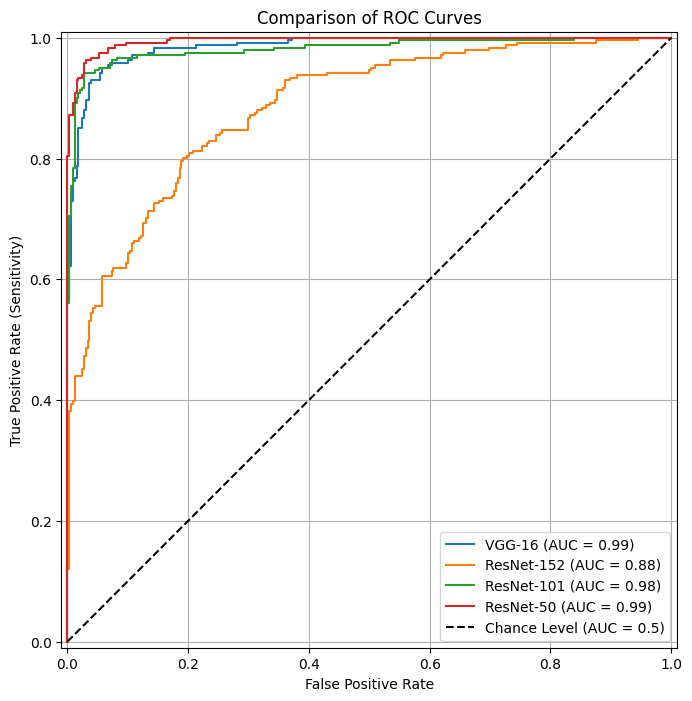

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import torchvision.models as models
from torchvision.models import resnet152, resnet101, resnet50
from torch.utils.data import DataLoader

fig, ax = plt.subplots(figsize=(8, 8))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Vgg
pc_model_vgg = models.vgg16(pretrained=True).to(device) 
for param in pc_model_vgg.features.parameters():
    param.requires_grad = False
#pc_model.fc = nn.Linear(pc_model.fc.in_features, 1)
# Get the number of features
num_features = pc_model_vgg.classifier[6].in_features

# replace the laat layer with new classifier layer
pc_model_vgg.classifier[6] = nn.Linear(num_features, 1)
pc_model_vgg.to(device)
pc_model_vgg.load_state_dict(torch.load('best_model_vgg.pth'))
y_true_vgg, y_scores_vgg = val(pc_model_vgg, device, test_loader)

# ResNet-152
pc_model_resnet152 = models.resnet152(pretrained=False).to(device)
pc_model_resnet152.fc = nn.Linear(pc_model_resnet152.fc.in_features, 1)
pc_model_resnet152.to(device)
pc_model_resnet152.load_state_dict(torch.load('best_model_resnet152.pth'))
y_true_resnet152, y_scores_resnet152 = val(pc_model_resnet152,
                                                  device, test_loader)
# ResNet-101
pc_model_resnet101 = models.resnet101(pretrained=True).to(device)
pc_model_resnet101.fc = nn.Linear(pc_model_resnet101.fc.in_features, 1)
pc_model_resnet101.to(device)
pc_model_resnet101.load_state_dict(torch.load('best_model_resnet101.pth'))
y_true_resnet101, y_scores_resnet101 = val(pc_model_resnet101,
                                                  device, test_loader)
# ResNet-50
pc_model_resnet50 = models.resnet50(pretrained=True).to(device)
pc_model_resnet50.fc = nn.Linear(pc_model_resnet50.fc.in_features, 1)
pc_model_resnet50.to(device)
pc_model_resnet50.load_state_dict(torch.load('best_model_resnet50.pth'))
y_true_resnet50, y_scores_resnet50 = val(pc_model_resnet50,
                                                  device, test_loader)

# Plot VGG Model Curve
RocCurveDisplay.from_predictions(y_true_vgg, y_scores_vgg, name='VGG-16', ax=ax)

# Plot ResNet-152 Model Curve
RocCurveDisplay.from_predictions(y_true_resnet152, y_scores_resnet152, name='ResNet-152', ax=ax)

# Plot ResNet-101 Model Curve
RocCurveDisplay.from_predictions(y_true_resnet101, y_scores_resnet101, name='ResNet-101', ax=ax)

# plot ResNet-50 Model Curve
RocCurveDisplay.from_predictions(y_true_resnet50, y_scores_resnet50, name='ResNet-50', ax=ax)

# --- 3. Finalize and Show the Plot ---
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)') # Add chance line
plt.title('Comparison of ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)
plt.show()